# Insurance Claims Severity

In [59]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
from scipy.stats import skew, boxcox
from scipy import sparse
import time
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

In [2]:
train_data = pd.read_csv('data/train.csv')
train_size = train_data.shape[0]
test_data = pd.read_csv('data/test.csv')
test_size = test_data.shape[0]

## Data Processing and Exploration

In [3]:
train_data = pd.read_csv('data/train.csv')
train_size = train_data.shape[0]
test_data = pd.read_csv('data/test.csv')
test_size = test_data.shape[0]

In [4]:
train_data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [5]:
test_data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [29]:
full_data = pd.concat([train_data,test_data],sort=False).reset_index(drop=True)
full_data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [11]:
data_types = full_data.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
con_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

id_col = 'id'
target_col = 'loss'
con_cols.remove('id')
con_cols.remove('loss')

print ("Categorical features:", cat_cols)
print ( "Numerica features:", con_cols)
print ( "ID: %s, target: %s" %( id_col, target_col))

Categorical features: ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat1

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


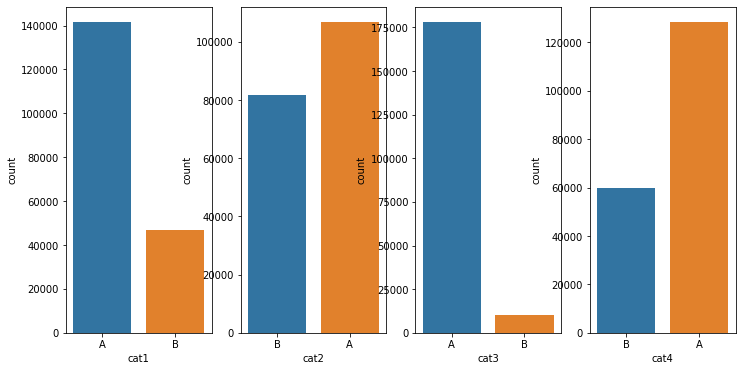

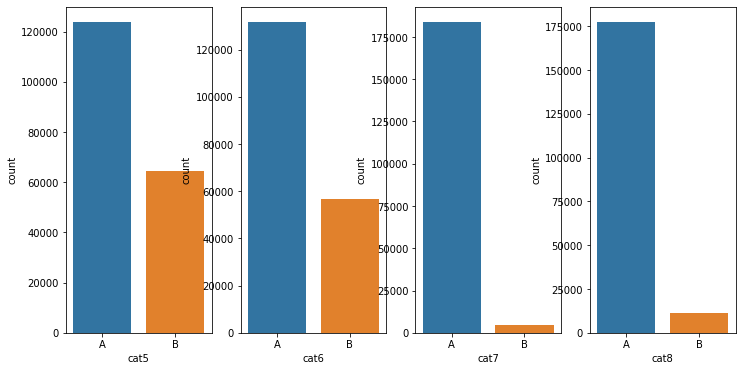

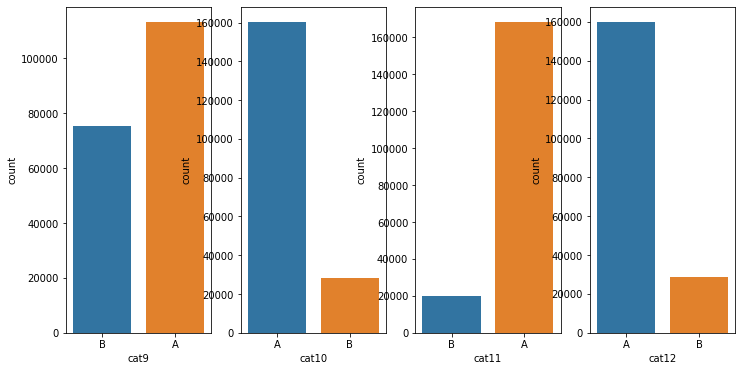

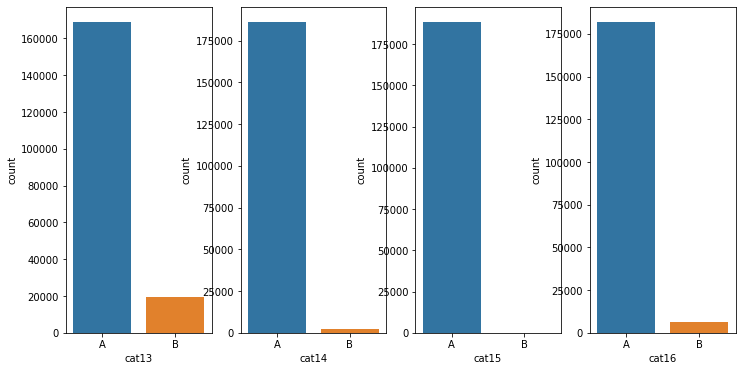

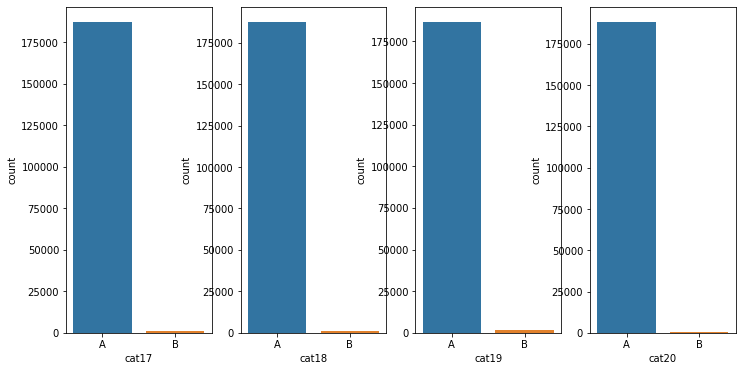

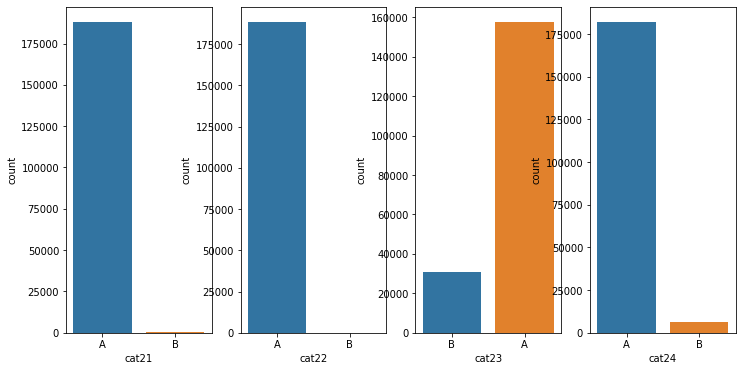

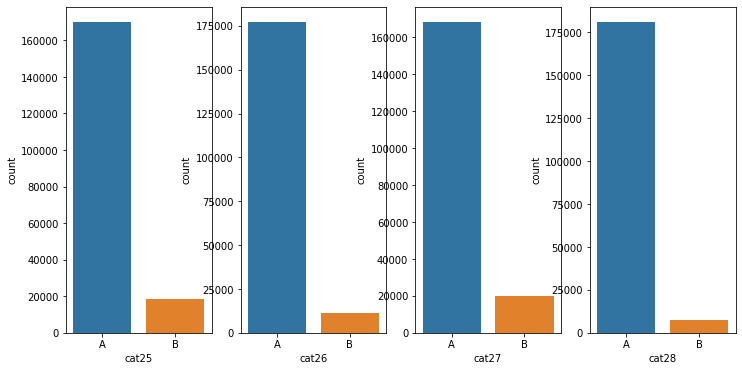

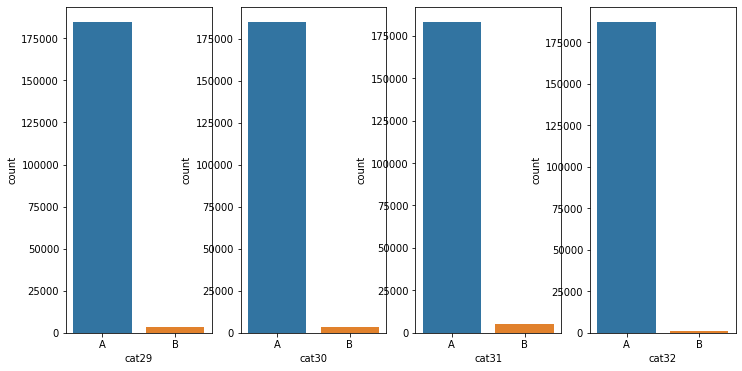

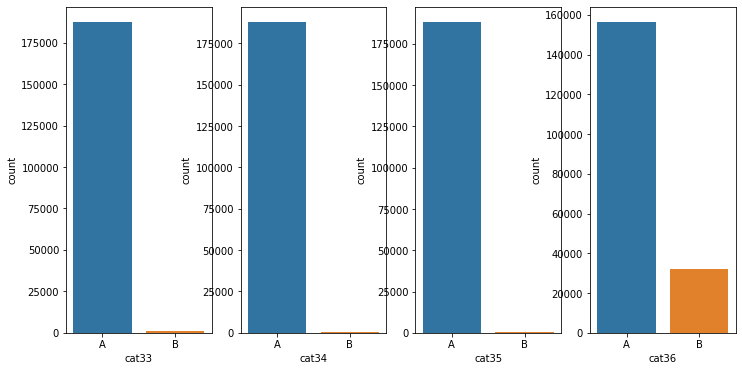

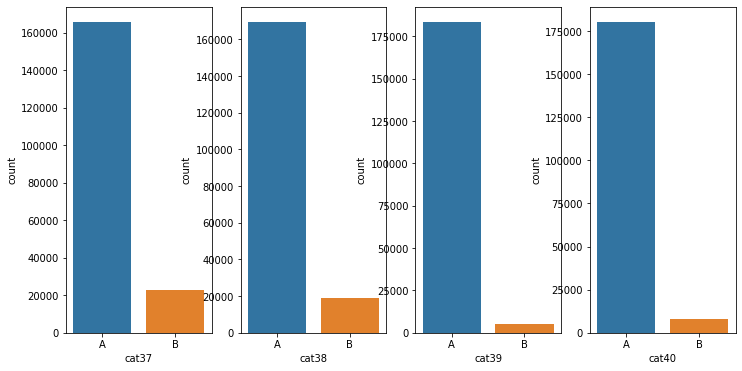

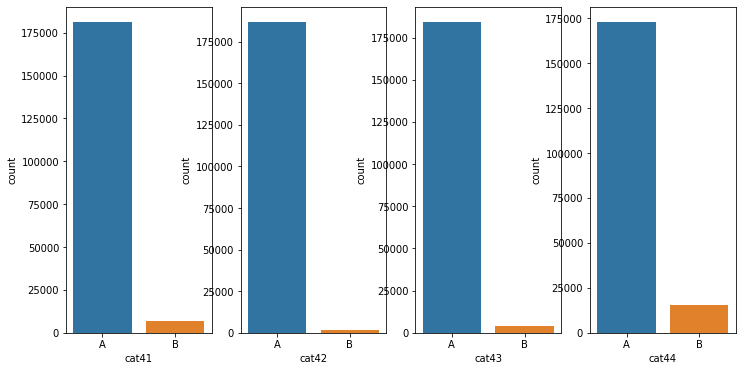

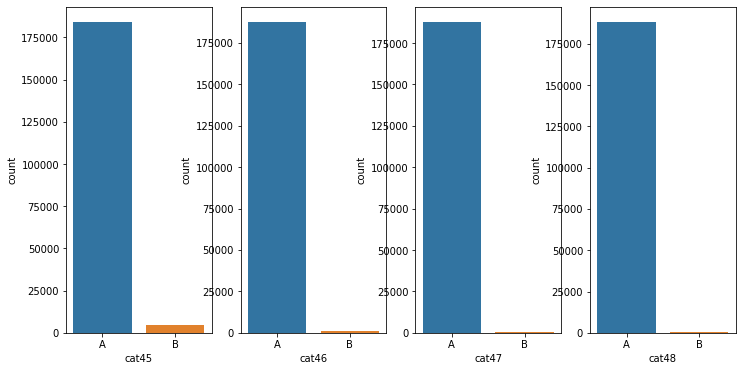

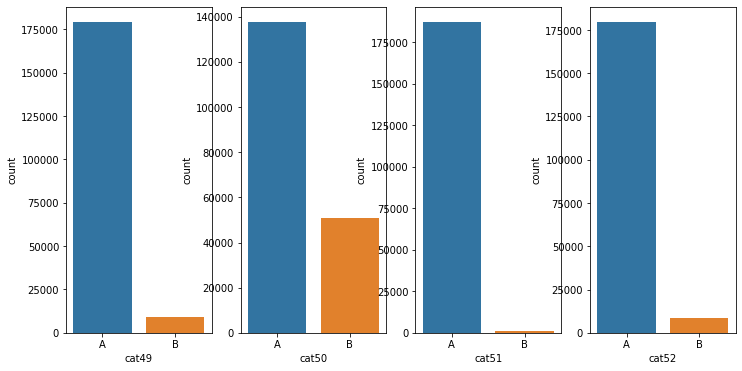

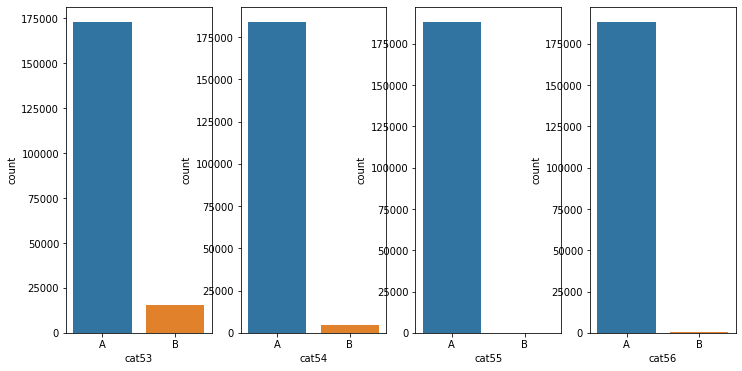

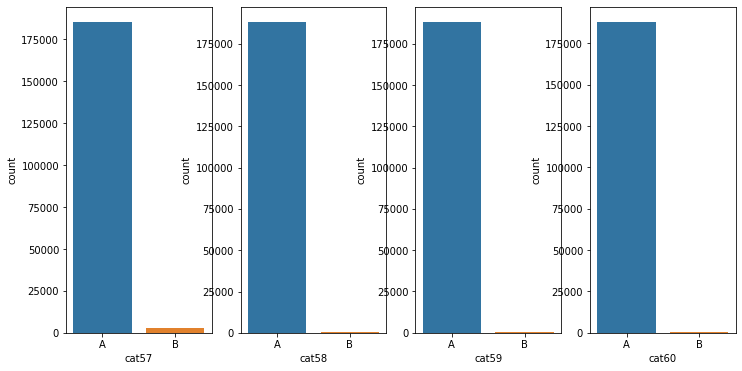

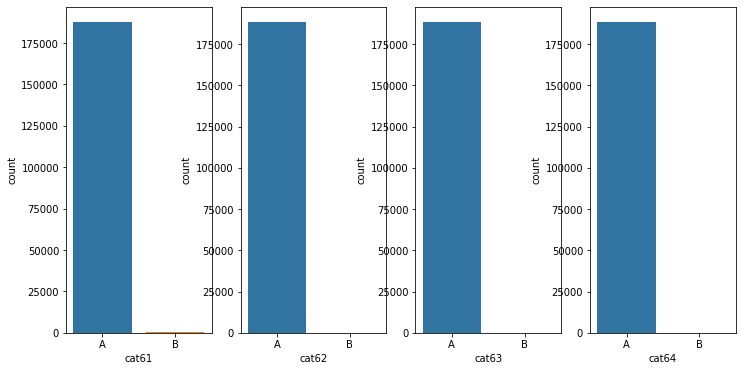

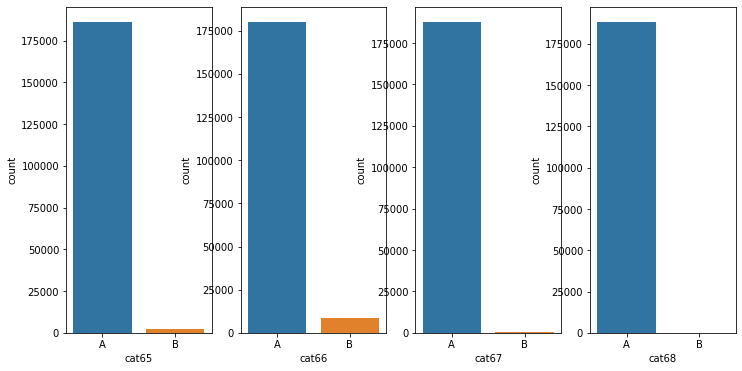

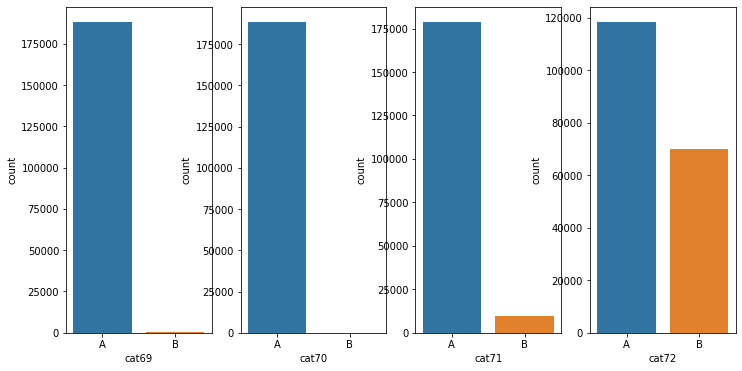

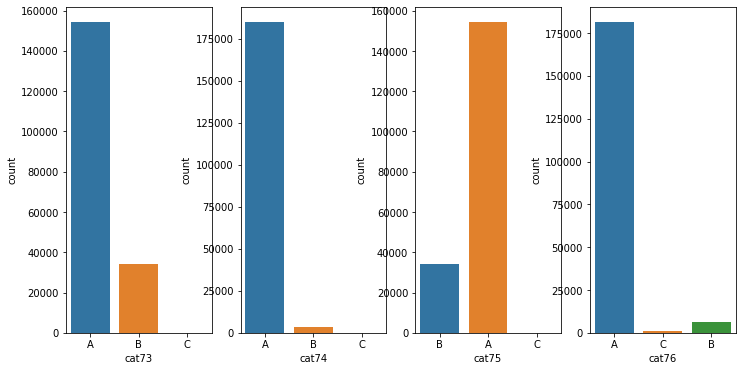

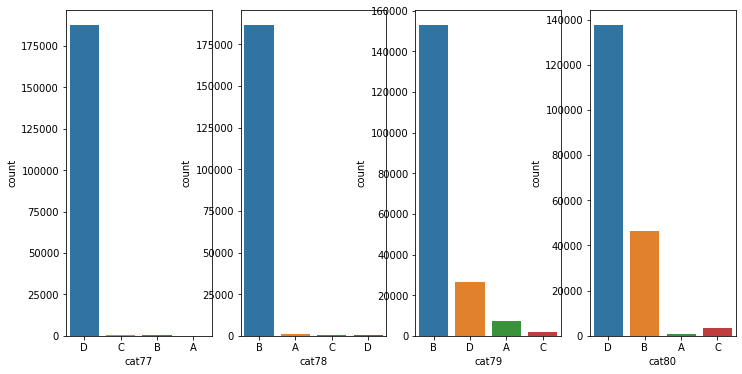

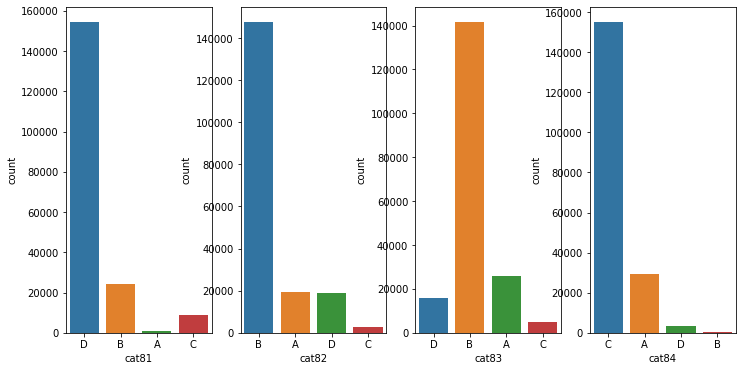

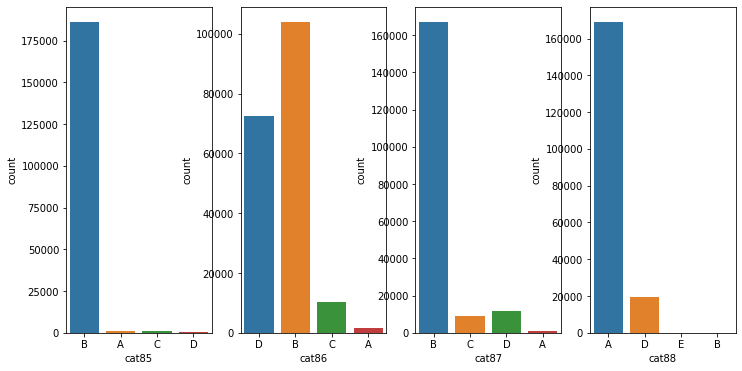

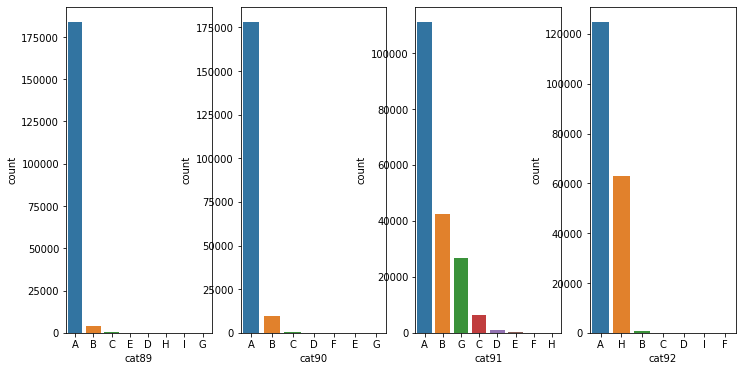

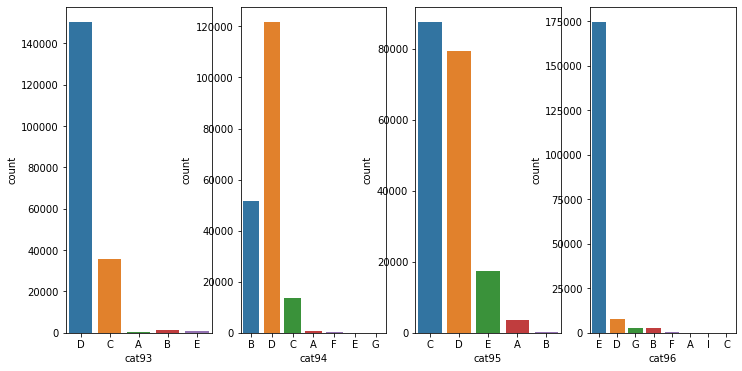

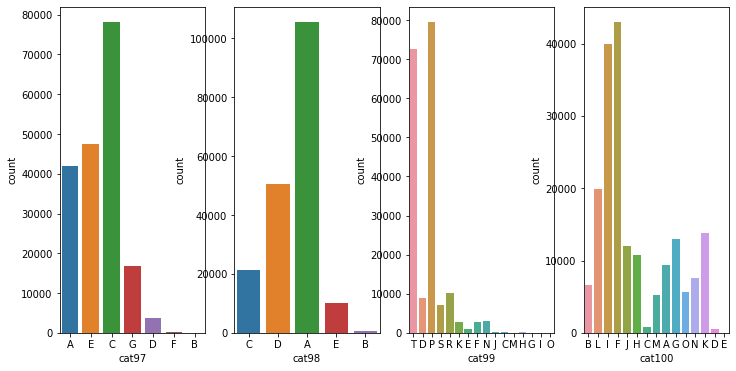

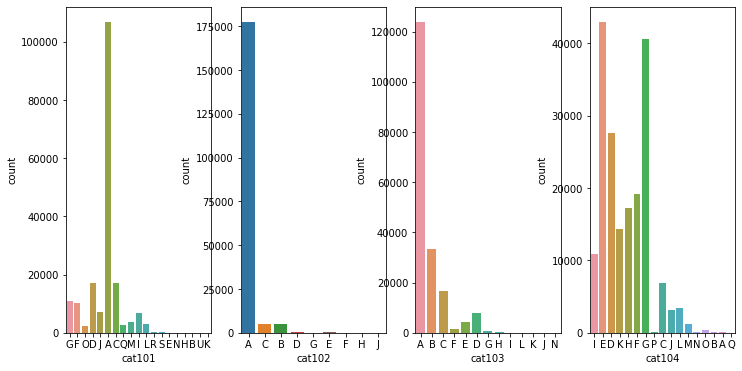

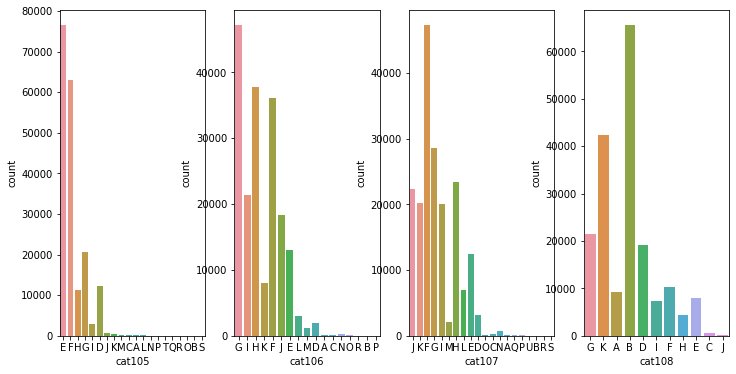

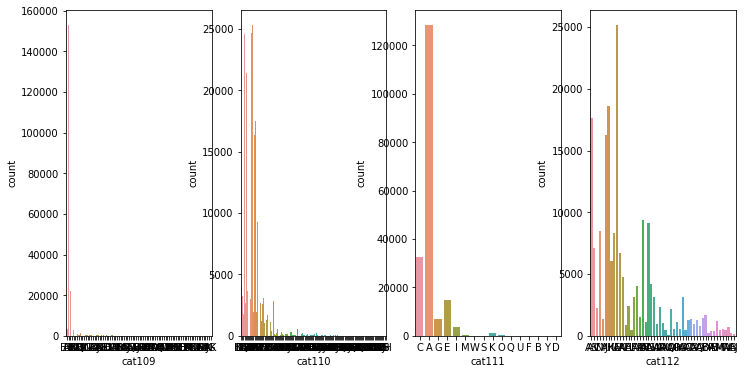

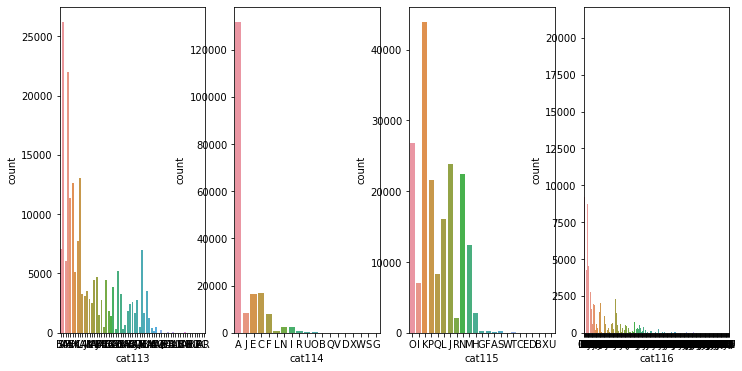

In [17]:
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 6))
    for j in range(n_cols):
        sns.countplot(x=cat_cols[i*n_cols+j], data=train_data, ax=ax[j])

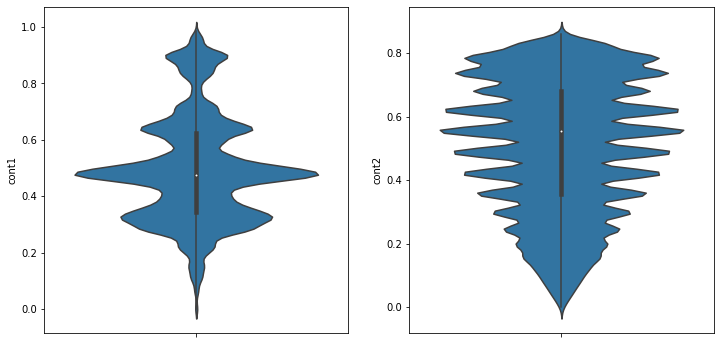

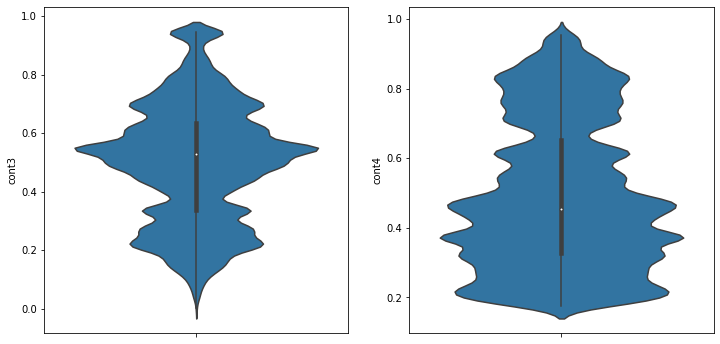

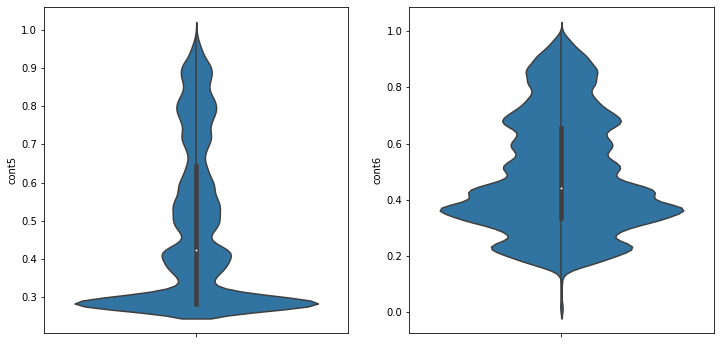

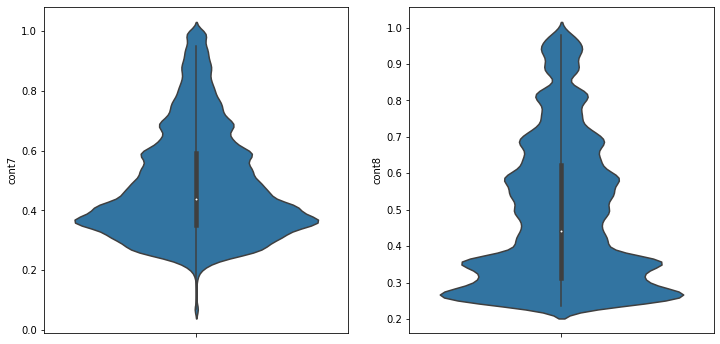

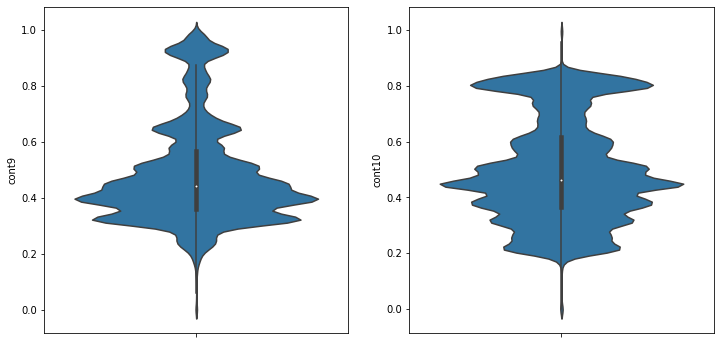

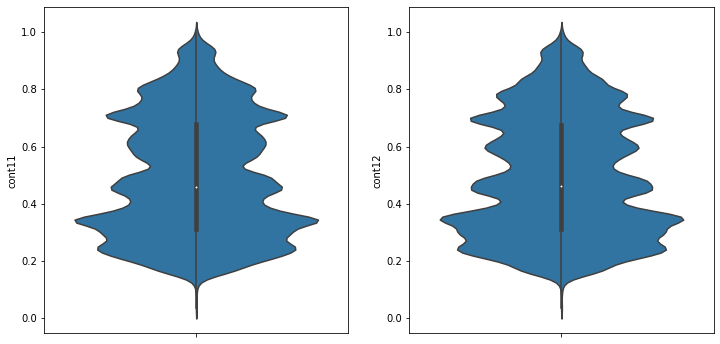

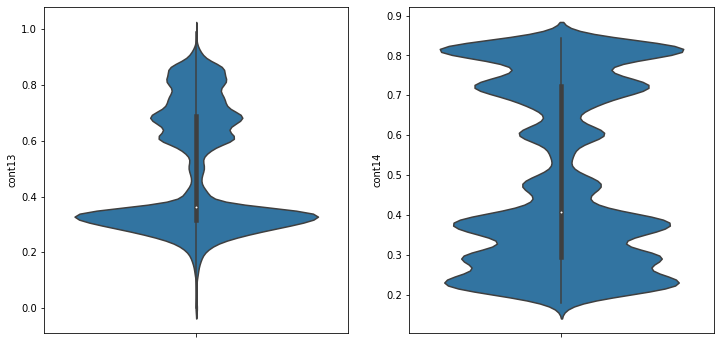

In [18]:
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 6))
    for j in range(n_cols):
        sns.violinplot(y=con_cols[i*n_cols+j], data=train_data, ax=ax[j])

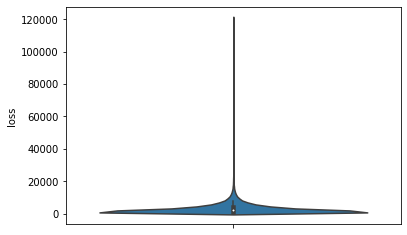

In [21]:
sns.violinplot(data=train_data,y=train_data["loss"])
plt.show()

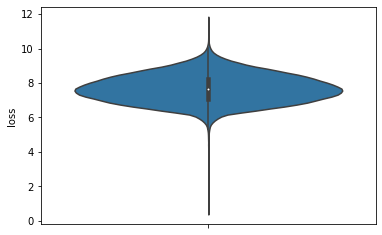

In [22]:
loss = np.log1p(train_data["loss"])
sns.violinplot(data=train_data,y=loss)
plt.show()

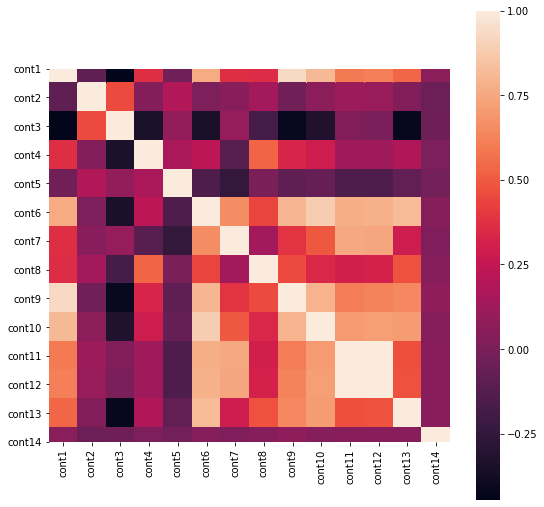

In [26]:
corrmat = train_data[con_cols].corr()

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(corrmat, square=True)
plt.show()

## Feature Engineering

### Categorical features 
1. Label Encoding
2. One Hot Encoding (get dummies)

In [33]:
full_data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0,1,0,1,0,0,0,0,1,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0,1,0,0,0,0,0,0,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,0,1,0,0,1,0,0,0,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,1,1,0,1,0,0,0,0,1,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,0,1,0,1,0,0,0,0,1,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [32]:
LBL = preprocessing.LabelEncoder()
start=time.time()
LE_map=dict()
for cat_col in cat_cols:
    full_data[cat_col] = LBL.fit_transform(full_data[cat_col])
    print(LBL.classes_)
    LE_map[cat_col]=dict(zip(LBL.classes_, LBL.transform(LBL.classes_)))
    
print ('Label enconding finished in %f seconds' % (time.time()-start))

['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['A' 'B' 'C']
['A' 'B' 'C']
['A' 'B' 'C']
['A' 'B' 'C']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'C' 'D']
['A' 'B' 'D' 'E']
['A' 'B'

In [34]:
LE_map

{'cat1': {'A': 0, 'B': 1},
 'cat2': {'A': 0, 'B': 1},
 'cat3': {'A': 0, 'B': 1},
 'cat4': {'A': 0, 'B': 1},
 'cat5': {'A': 0, 'B': 1},
 'cat6': {'A': 0, 'B': 1},
 'cat7': {'A': 0, 'B': 1},
 'cat8': {'A': 0, 'B': 1},
 'cat9': {'A': 0, 'B': 1},
 'cat10': {'A': 0, 'B': 1},
 'cat11': {'A': 0, 'B': 1},
 'cat12': {'A': 0, 'B': 1},
 'cat13': {'A': 0, 'B': 1},
 'cat14': {'A': 0, 'B': 1},
 'cat15': {'A': 0, 'B': 1},
 'cat16': {'A': 0, 'B': 1},
 'cat17': {'A': 0, 'B': 1},
 'cat18': {'A': 0, 'B': 1},
 'cat19': {'A': 0, 'B': 1},
 'cat20': {'A': 0, 'B': 1},
 'cat21': {'A': 0, 'B': 1},
 'cat22': {'A': 0, 'B': 1},
 'cat23': {'A': 0, 'B': 1},
 'cat24': {'A': 0, 'B': 1},
 'cat25': {'A': 0, 'B': 1},
 'cat26': {'A': 0, 'B': 1},
 'cat27': {'A': 0, 'B': 1},
 'cat28': {'A': 0, 'B': 1},
 'cat29': {'A': 0, 'B': 1},
 'cat30': {'A': 0, 'B': 1},
 'cat31': {'A': 0, 'B': 1},
 'cat32': {'A': 0, 'B': 1},
 'cat33': {'A': 0, 'B': 1},
 'cat34': {'A': 0, 'B': 1},
 'cat35': {'A': 0, 'B': 1},
 'cat36': {'A': 0, 'B': 1},
 

In [35]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(full_data[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))
print (full_data_sparse.shape)

C:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


One-hot-encoding finished in 1.808148 seconds
(313864, 1176)


### Continues features 
1. Apply box-cox transformations.
2. Apply standard scaling.

In [47]:
#from scipy.stats import skew, boxcox
skewed_cols = full_data[con_cols].apply(lambda x: skew(x.dropna()))
skewed_cols.sort_values()

cont2    -0.101841
cont9    -0.012046
cont3    -0.007023
cont1     0.004049
cont10    0.020122
cont11    0.023397
cont12    0.024871
cont6     0.038832
cont4     0.051627
cont7     0.054710
cont14    0.068549
cont13    0.092823
cont8     0.124111
cont5     0.205682
dtype: float64

(array([  422.,   305.,   697.,  1864.,  3324.,  1896.,  7754.,  9597.,
        29405., 34401., 19426., 23924., 65255., 22573., 15300., 33073.,
        12110.,  4749., 18766.,  9023.]),
 array([-3.55332265, -3.26512232, -2.97692198, -2.68872164, -2.4005213 ,
        -2.11232097, -1.82412063, -1.53592029, -1.24771996, -0.95951962,
        -0.67131928, -0.38311894, -0.09491861,  0.19328173,  0.48148207,
         0.7696824 ,  1.05788274,  1.34608308,  1.63428342,  1.92248375,
         2.21068409]),
 <a list of 20 Patch objects>)

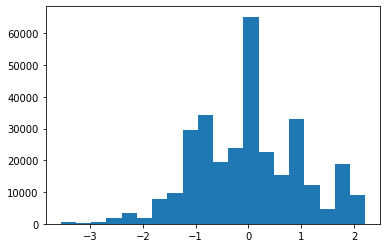

In [48]:
plt.hist(full_data['cont1'],bins = 20)

In [42]:
skewed_cols = skewed_cols[abs(skewed_cols) > 0.25].index.values
for skewed_col in skewed_cols:
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] + 1)

In [43]:
SSL = preprocessing.StandardScaler()
for con_col in con_cols:
     full_data[con_col] = SSL.fit_transform(full_data[con_col].values.reshape(-1,1))

## Model Building and Validation

In [52]:
full_data_sparse = sparse.hstack((full_data_sparse,full_data[con_cols]), format='csr')
print (full_data_sparse.shape)

(313864, 1190)


In [53]:
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200)
ID = full_data.id[:train_size].values

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

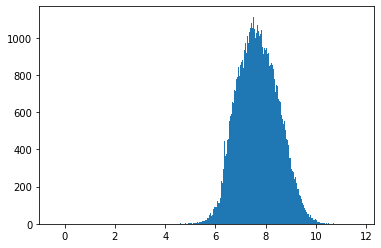

In [54]:
plt.hist(np.log(full_data[:train_size].loss),bins = 1000)

In [55]:
full_data[:train_size].loss

0          2213.18
1          1283.60
2          3005.09
3           939.85
4          2763.85
5          5142.87
6          1132.22
7          3585.75
8         10280.20
9          6184.59
10         6396.85
11         5965.73
12         1193.05
13         1071.77
14          585.18
15         1395.45
16         6609.32
17         2658.70
18         4167.32
19         3797.89
20         1155.48
21          891.14
22          765.97
23          771.58
24         7256.49
25         1528.73
26         4787.07
27         2163.97
28        11673.03
29         1753.50
            ...   
188288     2384.79
188289      961.10
188290     2786.15
188291     2157.66
188292      644.29
188293     4301.82
188294     4446.20
188295     1996.00
188296    16569.90
188297     4620.56
188298     3201.50
188299     1946.11
188300      839.41
188301      896.57
188302     1667.38
188303     4003.79
188304    12065.38
188305     4958.36
188306     2594.72
188307     1173.30
188308     2161.12
188309     4

In [56]:
from sklearn.metrics import mean_absolute_error
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def log_mae(y,yhat):
    return mean_absolute_error(np.exp(y), np.exp(yhat))

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

In [60]:
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [61]:
param_grid = {'objective':[logregobj],
              'learning_rate':[0.02, 0.04, 0.06, 0.08],
              'n_estimators':[1500],
              'max_depth': [9],
              'min_child_weight':[50],
              'subsample': [0.78],
              'colsample_bytree':[0.67],
              'gamma':[0.9],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78, score=-1133.763, total= 4.6min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78, score=-1139.233, total= 4.6min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.2min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78, score=-1136.070, total= 4.5min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.7min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78, score=-1134.291, total= 4.5min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.3min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78, score=-1137.829, total= 4.5min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.7min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78, score=-1140.533, total= 4.5min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 27.2min remaining:    0.0s


[CV]  colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78, score=-1138.556, total= 4.5min
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.04, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x0000024183AE8400>, seed=1234, subsample=0.78 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 31.7min remaining:    0.0s


KeyboardInterrupt: 

In [63]:
rgr = xgb.XGBRegressor(seed = 1234, 
                       learning_rate = 0.01, # smaller, better results, more time
                       n_estimators = 1500, # Number of boosted trees to fit.
                       max_depth=9, # the maximum depth of a tree
                       min_child_weight=50,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.67, gamma=0.9, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=9,
             min_child_weight=50, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1234, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=1234, silent=False,
             subsample=0.78, tree_method=None, validate_parameters=False,
             verbosity=None)

In [69]:
pred_y = np.exp(rgr.predict(test_x)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("data/sub.csv", index=False)
print ("Submission created.")

Submission created.


In [ ]:
len(rgr.feature_importances_)

In [ ]:
rgr.feature_importances_.sum()

In [ ]:
plt.bar(range(len(rgr.feature_importances_)), rgr.feature_importances_)
plt.show()

In [ ]:
xgb.plot_importance(rgr,max_num_features=5,importance_type='weight')

In [ ]:
np.argsort(rgr.feature_importances_)